#### Summary

- 672 nolu plant seçildi
- 120 saatlik featurelar verildi
- speed ve angle feature'ı yaratıldı 
- son 24 saat tahmin edilmeye çalışıldı

- **Linear**
    - dense - dropout - dense **Linear2**  
        - test wmape **0.3449** valid wmape **0.3324**
    - dense - dropout - dense - dropout - dense
        - test wmape **0.3504** valid wmape **0.3343**
    - dense - dense
        - test wmape **0.3622** valid wmape **0.3279**
- **Convolution**
    - Conv(64, 5) - MaxPooling(2) - Conv(64, 5) - MaxPooling(2) - dense - dense **CNN4**
        - test wmape **0.2697** valid wmape **0.3221** - testte en iyi
    - Conv(64, 3) - MaxPooling(2) - Conv(64, 3) - MaxPooling(2) - dense - dense
        - test wmape **0.2797** valid wmape **0.3230** - testte en iyi ikinci
    - Conv(64, 5) - MaxPooling(2) - Conv(64, 5) - MaxPooling(2) - Conv(64, 5) - Dropout(0.2) - dense - dense **CNN8**
        - test wmape **0.2839** valid wmape **0.3307** - testte en iyi üçüncü
    - Conv(64, 5) - MaxPooling(2) - Conv(64, 5) - Dropout(0.2) - dense - dense
        - test wmape **0.3080** valid wmape **0.3113** - validasyonda overall en iyi     
    - Conv(64, 5) - Dropout(0.2) - Conv(64, 5) - Dropout(0.2) - dense - dense
        - test wmape **0.2993** valid wmape **0.3161** - validasyonda en iyi ikinci
    - Conv(64, 24) - Conv(64, 24) - dense - dense
        - test wmape **0.3020** valid wmape **0.3211** - validasyonda en iyi üçüncü

- **Recurrent**
    - Conv(64, 5) - MaxPooling(2) - Conv(32, 5) - MaxPooling(2) - LSTM(32) - dense **RNN5**
        - test wmape **0.2640** valid wmape **0.3225** - testte overall en iyi 
    - LSTM(64) - LSTM(32) - dense
        - test wmape **0.2656** valid wmape **0.3240**
    - Conv(64, 5) - MaxPooling(2) - LSTM(32) - dense **RNN4**
        - test wmape **0.2670** valid wmape **0.3235** 
    
    
 Others:
 - 72 window size'de LSTM CNN'den kötü çalıştı
 - 144 window size, 969, no speed & angle
|         |   test_WMAPE |   valid_WMAPE |
|:--------|-------------:|--------------:|
| CNN4    |     0.269104 |      0.195882 |
| RNN4    |     0.286094 |      0.222127 |
| RNN2    |     0.301866 |      0.225191 |
| CNN8    |     0.306718 |      0.186613 |
| Linear2 |     0.591632 |      0.270318 |

- 144 window size, 969, with speed & angle
|         |   test_WMAPE |   valid_WMAPE |
|:--------|-------------:|--------------:|
| RNN5    |     0.268528 |      0.221569 |
| RNN4    |     0.272068 |      0.223544 |
| CNN8    |     0.281256 |      0.211298 |
| RNN2    |     0.290445 |      0.215808 |
| CNN4    |     0.297803 |      0.197183 |
| Linear2 |     0.35967  |      0.23287  |

 
 
 
 

In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers

2022-04-04 22:28:33.500095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 22:28:33.500110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")

In [4]:
# SELECTED_PLANT = 0
# PLANTS = sorted(df.rt_plant_id.unique())
# SELECTED_PLANT_ID = PLANTS[SELECTED_PLANT]

SELECTED_PLANT_ID = df.groupby("rt_plant_id").production.sum().sort_values(ascending=False).index[0]
print(SELECTED_PLANT_ID)
weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]
df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]
df = df[df["rt_plant_id"] == SELECTED_PLANT_ID].drop("rt_plant_id", axis=1)

969


In [5]:
GENERATE_SPEED_ANGLE = True

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
        
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]


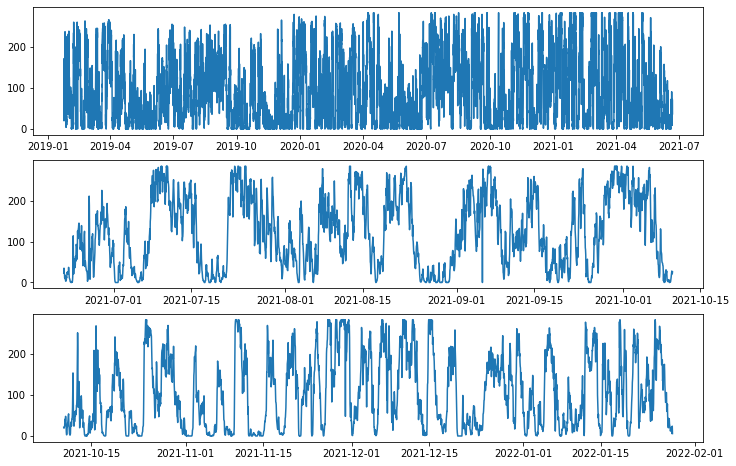

In [6]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(train_df.index, train_df.production)
plt.subplot(3, 1, 2)
plt.plot(valid_df.index, valid_df.production)
plt.subplot(3, 1, 3)
plt.plot(test_df.index, test_df.production)
plt.show()


In [7]:
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
valid_df = pd.DataFrame(scaler.transform(valid_df), index=valid_df.index, columns=valid_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

In [8]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, valid_df=valid_df, test_df=test_df,
                 columns=None, label_columns=None):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        if columns is None:
            columns = train_df.columns

        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(columns)}
        self.feature_column_indices = [v for k,v in self.column_indices.items() if k not in self.label_columns]
        self.feature_number = len(self.feature_column_indices)
        # list(self.label_columns_indices.values())

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, 1:]
        labels = features[:, self.labels_slice, :1]
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col='production', plant=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            label_col_index = self.label_columns_indices.get(plot_col, None)  
            input_values = inputs[n, :, plot_col_index]
            label_values = labels[n, :, label_col_index]
            plt.plot(self.input_indices, input_values, label='Inputs', marker='.', zorder=-10)
            plt.scatter(self.label_indices, label_values, edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                prediction_values = predictions[n, :, label_col_index]
                prediction_values = tf.clip_by_value(prediction_values, clip_value_min=0, clip_value_max=1)
                plt.scatter(self.label_indices, prediction_values, marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data, targets=None,
            sequence_length=self.total_window_size,
            # sequence_stride=24, shuffle=False,
            sequence_stride=1, shuffle=True,
            batch_size=64,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [9]:
def wmape(y_true, y_pred):
    total_abs_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(y_true)
    wmape = tf.realdiv(total_abs_diff, total)
    return wmape

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [11]:
OUT_STEPS = 24

multi_window = WindowGenerator(
    train_df=train_df, valid_df=valid_df, test_df=test_df,
    input_width=120, label_width=24, shift=0, label_columns=["production"])
multi_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['production']

2022-04-04 16:22:08.114332: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-04 16:22:08.114350: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (algopoly): /proc/driver/nvidia/version does not exist
2022-04-04 16:22:08.114757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


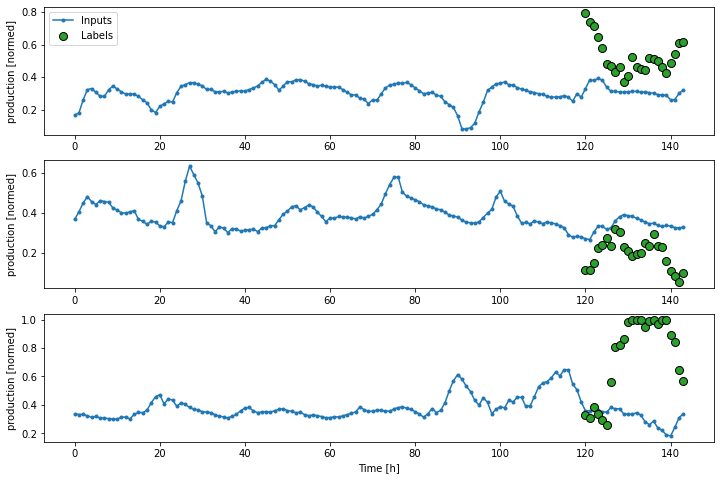

In [11]:
multi_window.plot()

In [12]:
multi_val_performance = {}
multi_performance = {}

## Dense

### Linear1

In [13]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120, 24)           408       
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense_1 (Dense)             (None, 24)                69144     
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 69,552
Trainable params: 69,552
Non-trainable params: 0
_________________________________________________________________


2022-04-04 22:42:03.751643: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-04 22:42:03.751664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (algopoly): /proc/driver/nvidia/version does not exist
2022-04-04 22:42:03.752272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['Linear1'] = model.evaluate(multi_window.valid)
multi_performance['Linear1'] = model.evaluate(multi_window.test)

In [ ]:
multi_window.plot(model, max_subplots=5)

### Linear2

In [16]:
multi_window.input_width, multi_window.feature_number

(120, 16)

In [14]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 120, 24)           408       
                                                                 
 dropout (Dropout)           (None, 120, 24)           0         
                                                                 
 flatten_1 (Flatten)         (None, 2880)              0         
                                                                 
 dense_3 (Dense)             (None, 24)                69144     
                                                                 
 reshape_1 (Reshape)         (None, 24, 1)             0         
                                                                 
Total params: 69,552
Trainable params: 69,552
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = compile_and_fit(model, multi_window)

Epoch 1/100
328/328 [==============================] - 1s 3ms/step - loss: 0.0398 - mean_absolute_error: 0.1481 - wmape: 0.4729 - val_loss: 0.0234 - val_mean_absolute_error: 0.1206 - val_wmape: 0.2711
Epoch 2/100
328/328 [==============================] - 1s 3ms/step - loss: 0.0259 - mean_absolute_error: 0.1186 - wmape: 0.3780 - val_loss: 0.0223 - val_mean_absolute_error: 0.1209 - val_wmape: 0.3175
Epoch 3/100
328/328 [==============================] - 1s 3ms/step - loss: 0.0247 - mean_absolute_error: 0.1164 - wmape: 0.3711 - val_loss: 0.0197 - val_mean_absolute_error: 0.1116 - val_wmape: 0.2845
Epoch 4/100
328/328 [==============================] - 1s 3ms/step - loss: 0.0240 - mean_absolute_error: 0.1149 - wmape: 0.3674 - val_loss: 0.0228 - val_mean_absolute_error: 0.1187 - val_wmape: 0.2656
Epoch 5/100
328/328 [==============================] - 1s 3ms/step - loss: 0.0235 - mean_absolute_error: 0.1138 - wmape: 0.3633 - val_loss: 0.0291 - val_mean_absolute_error: 0.1333 - val_wmape: 0.

In [15]:
multi_val_performance['Linear2'] = model.evaluate(multi_window.valid)
multi_performance['Linear2'] = model.evaluate(multi_window.test)

40/40 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_absolute_error: 0.1330 - wmape: 0.3597


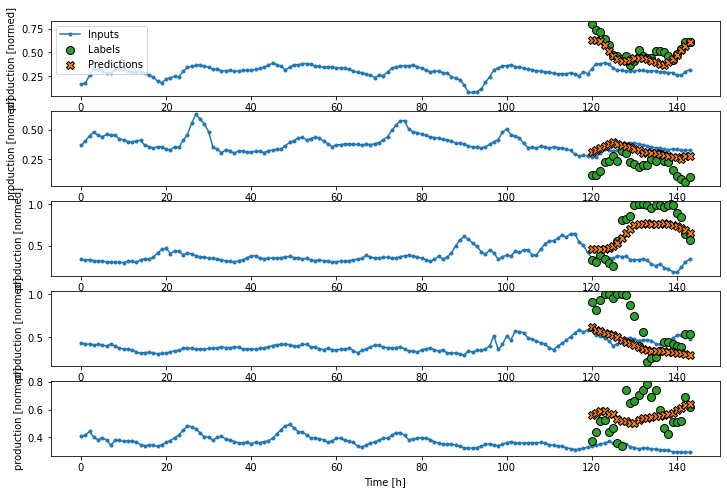

In [16]:
multi_window.plot(model, max_subplots=5)

### Linear3

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['Linear3'] = model.evaluate(multi_window.valid)
multi_performance['Linear3'] = model.evaluate(multi_window.test)

In [ ]:
multi_window.plot(model, max_subplots=5)

In [ ]:
multi_val_performance

In [ ]:
multi_performance

## Convolution

### Conv1

In [ ]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(256, CONV_WIDTH, activation="relu"))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN1'] = model.evaluate(multi_window.valid)
multi_performance['CNN1'] = model.evaluate(multi_window.test)

In [ ]:
multi_window.plot(model, max_subplots=5)

In [ ]:
pd.DataFrame(multi_val_performance, index=["loss", "MAE", "WMAPE"])

In [ ]:
pd.DataFrame(multi_performance, index=["loss", "MAE", "WMAPE"])

### Conv2

- CONV WIDTH 5 24ten daha iyi çalıştı

In [ ]:
CONV_WIDTH = 24

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(256, CONV_WIDTH, activation="relu"))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN2'] = model.evaluate(multi_window.valid)
multi_performance['CNN2'] = model.evaluate(multi_window.test)

In [ ]:
pd.DataFrame(multi_val_performance, index=["loss", "MAE", "WMAPE"])

In [ ]:
pd.DataFrame(multi_performance, index=["loss", "MAE", "WMAPE"])

### Conv3

In [ ]:
CONV_WIDTH = 24

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN3'] = model.evaluate(multi_window.valid)
multi_performance['CNN3'] = model.evaluate(multi_window.test)

### Conv4

In [17]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 64)           5184      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 72, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 68, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 34, 64)           0         
 1D)                                                             
                                                                 
 dense_2 (Dense)             (None, 34, 24)            1560      
                                                                 
 flatten_1 (Flatten)         (None, 816)              

In [18]:
history = compile_and_fit(model, multi_window)

Epoch 1/100
328/328 [==============================] - 3s 9ms/step - loss: 0.0358 - mean_absolute_error: 0.1370 - wmape: 0.4373 - val_loss: 0.0192 - val_mean_absolute_error: 0.1083 - val_wmape: 0.2407
Epoch 2/100
328/328 [==============================] - 3s 8ms/step - loss: 0.0186 - mean_absolute_error: 0.0988 - wmape: 0.3155 - val_loss: 0.0157 - val_mean_absolute_error: 0.0994 - val_wmape: 0.2215
Epoch 3/100
328/328 [==============================] - 3s 9ms/step - loss: 0.0164 - mean_absolute_error: 0.0926 - wmape: 0.2958 - val_loss: 0.0165 - val_mean_absolute_error: 0.1006 - val_wmape: 0.2244
Epoch 4/100
328/328 [==============================] - 3s 9ms/step - loss: 0.0147 - mean_absolute_error: 0.0882 - wmape: 0.2817 - val_loss: 0.0150 - val_mean_absolute_error: 0.0951 - val_wmape: 0.2140
Epoch 5/100
328/328 [==============================] - 3s 9ms/step - loss: 0.0131 - mean_absolute_error: 0.0846 - wmape: 0.2702 - val_loss: 0.0155 - val_mean_absolute_error: 0.0957 - val_wmape: 0.

In [19]:
multi_val_performance['CNN4'] = model.evaluate(multi_window.valid)
multi_performance['CNN4'] = model.evaluate(multi_window.test)

40/40 [==============================] - 0s 2ms/step - loss: 0.0247 - mean_absolute_error: 0.1133 - wmape: 0.2978


### Conv5

In [ ]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN5'] = model.evaluate(multi_window.valid)
multi_performance['CNN5'] = model.evaluate(multi_window.test)

### Conv6

In [ ]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN6'] = model.evaluate(multi_window.valid)
multi_performance['CNN6'] = model.evaluate(multi_window.test)

### Conv7

In [ ]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(128, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(4))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN7'] = model.evaluate(multi_window.valid)
multi_performance['CNN7'] = model.evaluate(multi_window.test)

### Conv8

In [20]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Dropout(.2))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 64)           5184      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 72, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 68, 64)            20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 34, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 34, 64)            20544     
                                                                 
 dropout_1 (Dropout)         (None, 34, 64)           

In [21]:
history = compile_and_fit(model, multi_window)

Epoch 1/100
328/328 [==============================] - 4s 11ms/step - loss: 0.0366 - mean_absolute_error: 0.1378 - wmape: 0.4398 - val_loss: 0.0199 - val_mean_absolute_error: 0.1108 - val_wmape: 0.2584
Epoch 2/100
328/328 [==============================] - 4s 11ms/step - loss: 0.0187 - mean_absolute_error: 0.0984 - wmape: 0.3135 - val_loss: 0.0167 - val_mean_absolute_error: 0.1018 - val_wmape: 0.2559
Epoch 3/100
328/328 [==============================] - 4s 11ms/step - loss: 0.0165 - mean_absolute_error: 0.0930 - wmape: 0.2965 - val_loss: 0.0192 - val_mean_absolute_error: 0.1066 - val_wmape: 0.2365
Epoch 4/100
328/328 [==============================] - 4s 11ms/step - loss: 0.0140 - mean_absolute_error: 0.0869 - wmape: 0.2770 - val_loss: 0.0159 - val_mean_absolute_error: 0.0952 - val_wmape: 0.2340
Epoch 5/100
328/328 [==============================] - 4s 11ms/step - loss: 0.0117 - mean_absolute_error: 0.0803 - wmape: 0.2561 - val_loss: 0.0176 - val_mean_absolute_error: 0.1008 - val_wmap

In [22]:
multi_val_performance['CNN8'] = model.evaluate(multi_window.valid)
multi_performance['CNN8'] = model.evaluate(multi_window.test)

40/40 [==============================] - 0s 3ms/step - loss: 0.0223 - mean_absolute_error: 0.1088 - wmape: 0.2813


### Conv9 

In [ ]:
CONV_WIDTH = 3

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN9'] = model.evaluate(multi_window.valid)
multi_performance['CNN9'] = model.evaluate(multi_window.test)

In [ ]:
pd.DataFrame(multi_performance, index=["loss", "MAE", "WMAPE"]).T

## Recurrent

In [23]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=2,
                        callbacks=[early_stopping])
    return history

### RNN1

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)


In [ ]:
multi_val_performance['RNN1'] = model.evaluate(multi_window.valid)
multi_performance['RNN1'] = model.evaluate(multi_window.test)


### RNN2

In [24]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.LSTM(24, return_sequences=False))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                3936      
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 reshape_3 (Reshape)         (None, 24, 1)             0         
                                                                 
Total params: 4,536
Trainable params: 4,536
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = compile_and_fit(model, multi_window)

Epoch 1/40
328/328 - 9s - loss: 0.0477 - mean_absolute_error: 0.1621 - wmape: 0.5176 - val_loss: 0.0252 - val_mean_absolute_error: 0.1239 - val_wmape: 0.2761 - 9s/epoch - 29ms/step
Epoch 2/40
328/328 - 8s - loss: 0.0240 - mean_absolute_error: 0.1128 - wmape: 0.3593 - val_loss: 0.0220 - val_mean_absolute_error: 0.1152 - val_wmape: 0.2558 - 8s/epoch - 24ms/step
Epoch 3/40
328/328 - 8s - loss: 0.0215 - mean_absolute_error: 0.1057 - wmape: 0.3364 - val_loss: 0.0224 - val_mean_absolute_error: 0.1151 - val_wmape: 0.2585 - 8s/epoch - 24ms/step
Epoch 4/40
328/328 - 9s - loss: 0.0200 - mean_absolute_error: 0.1015 - wmape: 0.3234 - val_loss: 0.0202 - val_mean_absolute_error: 0.1108 - val_wmape: 0.2474 - 9s/epoch - 26ms/step
Epoch 5/40
328/328 - 8s - loss: 0.0186 - mean_absolute_error: 0.0978 - wmape: 0.3117 - val_loss: 0.0226 - val_mean_absolute_error: 0.1149 - val_wmape: 0.2575 - 8s/epoch - 24ms/step
Epoch 6/40
328/328 - 8s - loss: 0.0178 - mean_absolute_error: 0.0955 - wmape: 0.3044 - val_loss

In [26]:
multi_val_performance['RNN2'] = model.evaluate(multi_window.valid)
multi_performance['RNN2'] = model.evaluate(multi_window.test)


40/40 [==============================] - 0s 8ms/step - loss: 0.0247 - mean_absolute_error: 0.1121 - wmape: 0.2904


### RNN3

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32, return_sequences=False))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['RNN3'] = model.evaluate(multi_window.valid)
multi_performance['RNN3'] = model.evaluate(multi_window.test)


### RNN4

In [27]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(32, return_sequences=False))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 144, 64)           5184      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 72, 64)           0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 24)                792       
                                                                 
 reshape_4 (Reshape)         (None, 24, 1)             0         
                                                                 
Total params: 18,392
Trainable params: 18,392
Non-trainable params: 0
__________________________________________________

In [28]:
history = compile_and_fit(model, multi_window)

Epoch 1/40
328/328 - 7s - loss: 0.0426 - mean_absolute_error: 0.1509 - wmape: 0.4825 - val_loss: 0.0280 - val_mean_absolute_error: 0.1307 - val_wmape: 0.2966 - 7s/epoch - 22ms/step
Epoch 2/40
328/328 - 6s - loss: 0.0215 - mean_absolute_error: 0.1054 - wmape: 0.3357 - val_loss: 0.0203 - val_mean_absolute_error: 0.1111 - val_wmape: 0.2560 - 6s/epoch - 18ms/step
Epoch 3/40
328/328 - 6s - loss: 0.0183 - mean_absolute_error: 0.0966 - wmape: 0.3081 - val_loss: 0.0182 - val_mean_absolute_error: 0.1050 - val_wmape: 0.2334 - 6s/epoch - 18ms/step
Epoch 4/40
328/328 - 6s - loss: 0.0169 - mean_absolute_error: 0.0924 - wmape: 0.2951 - val_loss: 0.0217 - val_mean_absolute_error: 0.1129 - val_wmape: 0.2513 - 6s/epoch - 18ms/step
Epoch 5/40
328/328 - 6s - loss: 0.0160 - mean_absolute_error: 0.0899 - wmape: 0.2868 - val_loss: 0.0240 - val_mean_absolute_error: 0.1174 - val_wmape: 0.2601 - 6s/epoch - 18ms/step
Epoch 6/40
328/328 - 6s - loss: 0.0150 - mean_absolute_error: 0.0873 - wmape: 0.2787 - val_loss

In [29]:
multi_val_performance['RNN4'] = model.evaluate(multi_window.valid)
multi_performance['RNN4'] = model.evaluate(multi_window.test)


40/40 [==============================] - 0s 6ms/step - loss: 0.0210 - mean_absolute_error: 0.1052 - wmape: 0.2721


### RNN5

In [33]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(multi_window.input_width, multi_window.feature_number)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(32, return_sequences=False))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 144, 64)           5184      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 72, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 72, 32)            10272     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 36, 32)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 24)               

In [34]:
history = compile_and_fit(model, multi_window)

Epoch 1/40
328/328 - 6s - loss: 0.0493 - mean_absolute_error: 0.1662 - wmape: 0.5275 - val_loss: 0.0252 - val_mean_absolute_error: 0.1265 - val_wmape: 0.2823 - 6s/epoch - 19ms/step
Epoch 2/40
328/328 - 4s - loss: 0.0227 - mean_absolute_error: 0.1080 - wmape: 0.3438 - val_loss: 0.0184 - val_mean_absolute_error: 0.1061 - val_wmape: 0.2359 - 4s/epoch - 13ms/step
Epoch 3/40
328/328 - 4s - loss: 0.0193 - mean_absolute_error: 0.0987 - wmape: 0.3146 - val_loss: 0.0195 - val_mean_absolute_error: 0.1087 - val_wmape: 0.2417 - 4s/epoch - 13ms/step
Epoch 4/40
328/328 - 4s - loss: 0.0174 - mean_absolute_error: 0.0936 - wmape: 0.2982 - val_loss: 0.0179 - val_mean_absolute_error: 0.1029 - val_wmape: 0.2306 - 4s/epoch - 14ms/step
Epoch 5/40
328/328 - 4s - loss: 0.0160 - mean_absolute_error: 0.0900 - wmape: 0.2866 - val_loss: 0.0167 - val_mean_absolute_error: 0.0995 - val_wmape: 0.2230 - 4s/epoch - 14ms/step
Epoch 6/40
328/328 - 4s - loss: 0.0155 - mean_absolute_error: 0.0884 - wmape: 0.2820 - val_loss

In [35]:
multi_val_performance['RNN5'] = model.evaluate(multi_window.valid)
multi_performance['RNN5'] = model.evaluate(multi_window.test)


40/40 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.1028 - wmape: 0.2685


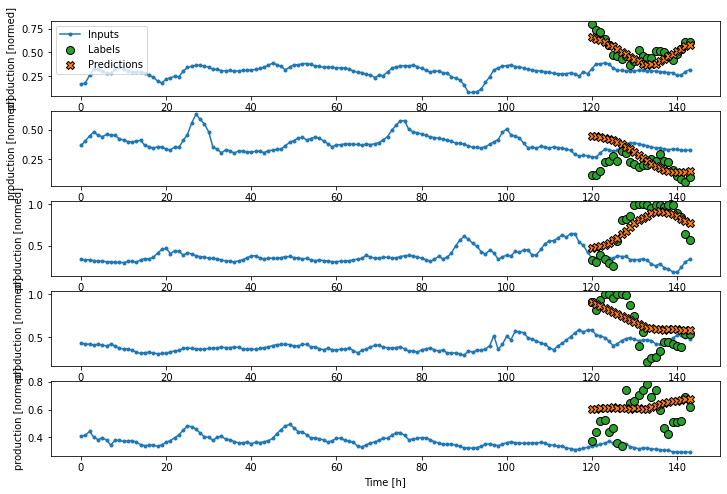

In [36]:
multi_window.plot(model, max_subplots=5)

## Comparison

In [37]:
output = pd.concat([
    pd.DataFrame(multi_performance).T, 
    pd.DataFrame(multi_val_performance).T], axis=1)
output.columns = ["test_loss", "test_MAE", "test_WMAPE", "valid_loss", "valid_MAE", "valid_WMAPE"]
output[["test_WMAPE", "valid_WMAPE"]].sort_values("test_WMAPE")

,test_WMAPE,valid_WMAPE
RNN5,0.268528,0.221569
RNN4,0.272068,0.223544
CNN8,0.281256,0.211298
RNN2,0.290445,0.215808
CNN4,0.297803,0.197183
Linear2,0.359670,0.232870


In [38]:
# !pip install tabulate
print(output[["test_WMAPE", "valid_WMAPE"]].sort_values("test_WMAPE").to_markdown())

|         |   test_WMAPE |   valid_WMAPE |
|:--------|-------------:|--------------:|
| RNN5    |     0.268528 |      0.221569 |
| RNN4    |     0.272068 |      0.223544 |
| CNN8    |     0.281256 |      0.211298 |
| RNN2    |     0.290445 |      0.215808 |
| CNN4    |     0.297803 |      0.197183 |
| Linear2 |     0.35967  |      0.23287  |


In [ ]:
def plot_metrics(sort_test=True):
    plt.figure(figsize=(12, 15))
    x = np.arange(len(multi_performance))
    width = 0.3
    
    for n in range(len(model.metrics_names)):
        plt.subplot(len(model.metrics_names), 1, n+1)
        metric_name = model.metrics_names[n]
        val_mae = [v[n] for v in multi_val_performance.values()]
        test_mae = [v[n] for v in multi_performance.values()]
        
        if sort_test:
            sorted_index = np.argsort(test_mae)
        else:
            sorted_index = np.argsort(val_mae)
        val_mae = [val_mae[i] for i in sorted_index]
        test_mae = [test_mae[i] for i in sorted_index]

        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=[list(multi_performance.keys())[i] for i in sorted_index], rotation=45)
        plt.ylabel(metric_name)
        plt.title(metric_name)
        if n == 0:
            _ = plt.legend()

In [ ]:
plot_metrics()